<a href="https://colab.research.google.com/github/sunhuanhuan920/ECE1512_2023F_ProjectRepo_Zhenhuan_Sun/blob/main/Project%20A/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2: Knowledge Distillation in MHIST Dataset**

# Question 1

(a). MHIST dataset contains images of colorectal polyps. Both pre-trained ResNet50 and pre-trained MobileNetV2 do not possess the capability to classify colorectal polyps, as ImageNet does not contain any colorectal polyps examples. However, the first few layers of DNN, especially those trained on ImageNet, can usually capture general features in images like edges, textures, and shapes. These features are often generic and can be beneficial for many other visual classification tasks. By using the architecture of ResNet50 or MobileNetV2 and their trained weights, we can leverage their already-learned primitive features identifiers for our tasks. In addition, the final layer of DNNs is usually customized for the dataset they are trained on. For example, different dataset may contain different number of classes, and thus having different number of neurons in their last layers. By leveraging fine-tuning processes, even though the MHIST dataset have different classes than ImageNet, we can replace the output layer of ResNet50 and MobileNetV2 with custom layers tailored for MHIST, then freeze the per-trained layers and fine-tunes the parameters on those custom layers based on the MHIST dataset.

(b). Residual block is a fundamental unit in Residual Network architecutres. It usually contains 2 convolutional layers with batch normalization layer attached after each, activation functions, and most importantly a residual path that connect the input of block to the output, creating skip connection.

(c). Compared to ResNetV1 which has the following order within the residual block: Conv -> BN -> ReLU, the order within the residual block has changed to: BN -> ReLU -> Conv in ResNetV2. In addtion, in ResNetV1, ReLU activation is applied after the addition of the residual path. In ResNetV2, no activation is applied after addition.

(d). MobileNetV1 used depthwise separable convolutions to reduce computational cost and build lightweight DNNs. MobileNetV2 build upon this by adding linear bottlenecks between the layers and connecting bottlenecks with residual path, which forms an inverted residual block.

(e). This is due to the presence of residual connection in the residual block. For example, we can express the function in residual block as $f(x) + x$, where $f(x)$ is the function performed by the original layers and $+ x$ is the residual connection in the block. If we take the derivative of $f(x) + x$ with respect to $x$, we will get $\frac{d}{dx} f(x) + 1$. The vanishing gradient problem is usually occured during backpropogation where gredients are repeatedly multiplied by some small number during the backpropogation along the $f(x)$ path, i.e., $\frac{d}{dx} f(x)$. The $+ 1$ gives the backpropogated gradient a path to avoid the processing done in $f(x)$ and flow uninterruptly, which essentially mitigate the problem of vanishing gradient.

(f). MobileNetV2 is considered as a lightweight model. It and its predecessor MobileNetV1 are designed for mobile devices with limited computation resources. Thus, its architecture, such as depthwise separable convolutions and inverted residual blocks, are tailored to reduce the number of FLOPs and parameters required to make prediction and provide a good balance between performance and computational efficiency.

# Question 2

# Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Project_A_Supp/mhist_dataset

# !unzip images.zip

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Project_A_Supp/mhist_dataset


In [2]:
import pandas as pd

annotations = pd.read_csv('annotations.csv')
annotations.head(10)

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train
5,MHIST_aag.png,HP,2,test
6,MHIST_aah.png,HP,2,test
7,MHIST_aai.png,HP,3,train
8,MHIST_aaj.png,HP,0,train
9,MHIST_aak.png,HP,2,train


In [3]:
train_annotations = annotations[annotations['Partition'] == 'train']
train_annotations.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


In [4]:
test_annotations = annotations[annotations['Partition'] == 'test']
test_annotations.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
5,MHIST_aag.png,HP,2,test
6,MHIST_aah.png,HP,2,test
14,MHIST_aaq.png,SSA,5,test
15,MHIST_aar.png,HP,0,test
22,MHIST_aay.png,HP,1,test


In [5]:
import os
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MHISTDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.img_paths = [os.path.join(img_dir, fname) for fname in annotations.iloc[:, 0]]
        # 0 for SSA, 1 for HP
        self.labels = annotations.iloc[:, 1].apply(lambda x: 0 if x == "SSA" else 1).tolist()
        self.transform = transform

        # Load all images into memory
        self.loaded_images = []
        self.load_images()

    def load_images(self):
        with tqdm.tqdm(total=len(self.img_paths), desc="Loading images", dynamic_ncols=True) as pbar:
            for img_path in self.img_paths:
                image = Image.open(img_path).convert('RGB')
                self.loaded_images.append(image)
                pbar.update(1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        image = self.loaded_images[index]

        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of subprocesses to use for data loading
num_workers = 2
# How many samples per batch to load
# batch_size = 32

# Define plain transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# Define training data transformation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.80, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])

# define test data transformation
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MHISTDataset(annotations=train_annotations, img_dir='./images/', transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

test_dataset = MHISTDataset(annotations=test_annotations, img_dir='./images/', transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

Loading images: 100%|██████████| 977/977 [07:26<00:00,  2.19it/s]


In [7]:
print("Number of samples in training set:", len(train_dataset))
print("Number of samples in test set:", len(test_dataset))

# Fetch a single sample (image and label) from the training dataset
image, label = train_dataset[0]
# Each image has shape: [channels, height, width]
print("Shape of the image:", image.shape)

Number of samples in training set: 2175
Number of samples in test set: 977
Shape of the image: torch.Size([3, 224, 224])


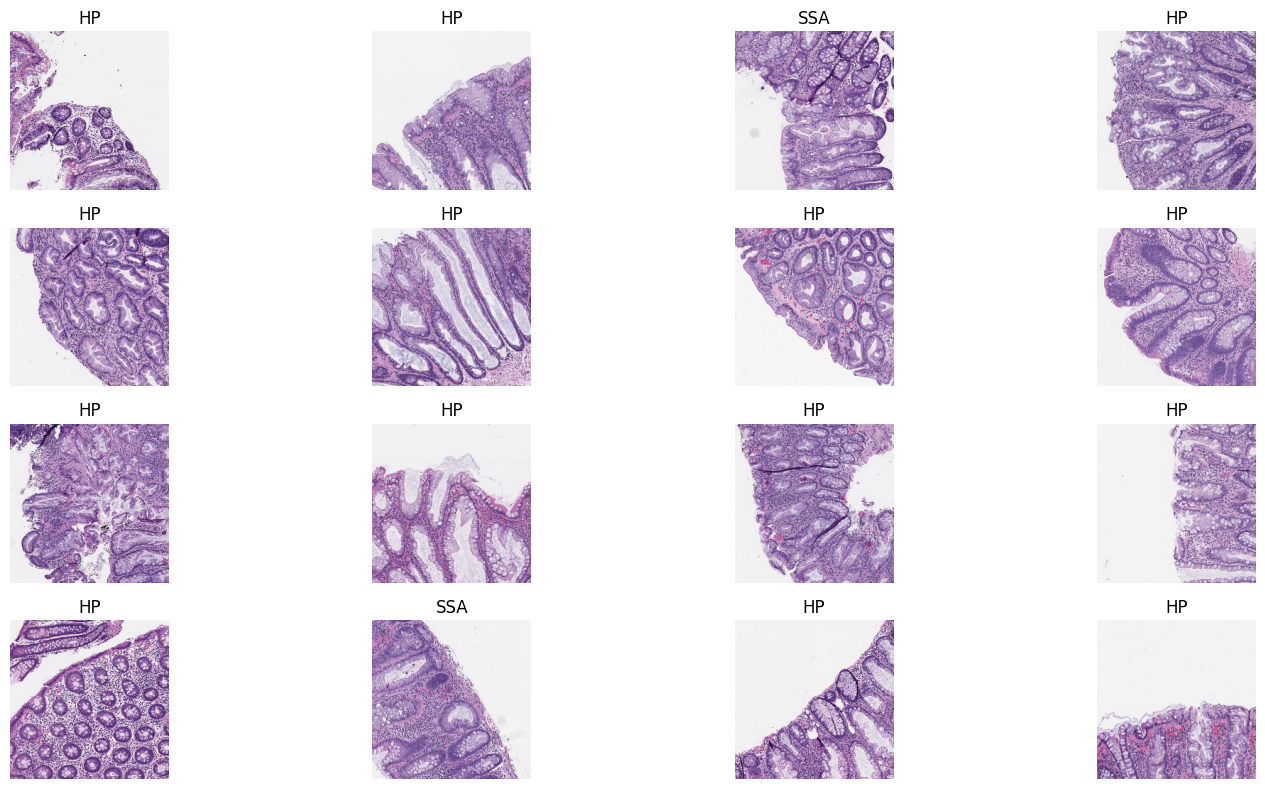

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to unnormalize and display an image
def imshow(ax, img):
    img = img.cpu().numpy().transpose((1, 2, 0))  # Convert from Tensor image and ensure it's on CPU
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1 to display correctly
    ax.imshow(img)
    ax.axis('off')

# Get a batch of images and labels
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# Convert labels back to their string representation for visualization
label_map = {0: "SSA", 1: "HP"}
labels = [label_map[int(i)] for i in labels]

# Display images with labels
fig = plt.figure(figsize=(16, 8))
for idx in np.arange(16):  # Displaying first 16 images of the batch
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    imshow(ax, images[idx])
    ax.set_title(labels[idx])
plt.tight_layout()
plt.show()

# Model creation

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import ResNet50_Weights, MobileNet_V2_Weights

**Teacher model**

In [10]:
class Teacher:
    def __init__(self, device, num_classes=2, learning_rate=0.0001):
        self.device = device
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = self.initialize_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.initialize_optimizer()

    def initialize_model(self):
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        model = model.to(self.device)
        return model

    def initialize_optimizer(self):
        params_to_update = list(self.model.layer4.parameters()) + list(self.model.fc.parameters())
        optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
        return optimizer

    def print_model(self):
        print(self.model)

    def print_trainable_layers(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f"Trainable layer: {name}")
            else:
                print(f"Non-trainable layer: {name}")

**Student model**

In [11]:
class Student:
    def __init__(self, device, num_classes=2, learning_rate=0.001):
        self.device = device
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = self.initialize_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.initialize_optimizer()

    def initialize_model(self):
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Modify the classifier
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes)
        model = model.to(self.device)
        return model

    def initialize_optimizer(self):
        # Update only the parameters of the classifier layer
        params_to_update = list(self.model.classifier[1].parameters())
        optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
        return optimizer

    def print_model(self):
        print(self.model)

    def print_trainable_layers(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f"Trainable layer: {name}")
            else:
                print(f"Non-trainable layer: {name}")

# Train and evaluation function

**Transfer learning**

In [12]:
def train_model_TL(model_wrapper, save_path, num_epochs=25):

    test_loss_min = np.Inf  # Track change in test loss

    for epoch in range(1, num_epochs + 1):
        # Track test loss
        test_loss = 0.0
        model_wrapper.model.train()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(model_wrapper.device), labels.to(model_wrapper.device)
            # Clear the gradients of all optimized variables
            model_wrapper.optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model_wrapper.model(inputs)
            # Compute the batch loss
            loss = model_wrapper.criterion(output, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            model_wrapper.optimizer.step()

        model_wrapper.model.eval()
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(model_wrapper.device), labels.to(model_wrapper.device)
            output = model_wrapper.model(inputs)
            loss = model_wrapper.criterion(output, labels)
            test_loss += loss.item() * inputs.size(0)

        test_loss = test_loss / len(test_dataloader.dataset)
        print('Epoch: {} \tTest Loss: {:.6f}'.format(epoch, test_loss))

        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
                test_loss_min, test_loss))
            torch.save(model_wrapper.model.state_dict(), save_path)
            test_loss_min = test_loss

**Knowledge distillation**

In [13]:
def train_model_KD(teacher_model_wrapper, student_model_wrapper, alpha, temperature, save_path, num_epochs=25):

    test_loss_min = np.Inf  # Track change in test loss

    # Set teacher to evaluation mode
    teacher_model_wrapper.model.eval()

    for epoch in range(1, num_epochs+1):
        test_loss = 0.0
        student_model_wrapper.model.train()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(student_model_wrapper.device), labels.to(student_model_wrapper.device)
            student_model_wrapper.optimizer.zero_grad()
            # Get teacher's outputs
            with torch.no_grad():
                teacher_outputs = teacher_model_wrapper.model(inputs)
            # Get student's outputs
            student_outputs = student_model_wrapper.model(inputs)
            # Compute hard label loss
            loss_hard = student_model_wrapper.criterion(student_outputs, labels)
            # Compute soft label loss
            soft_labels = torch.nn.functional.softmax(teacher_outputs / temperature, dim=-1)
            log_probs = torch.nn.functional.log_softmax(student_outputs / temperature, dim=-1)
            # Compute the cross-entropy loss between the soft targets and the student probility distribution
            loss_soft = -(soft_labels * log_probs).sum(dim=-1).mean() * (temperature ** 2)
            # Combine the two losses
            loss = alpha * loss_soft + (1 - alpha) * loss_hard
            # Backpropagate
            loss.backward()
            student_model_wrapper.optimizer.step()

        student_model_wrapper.model.eval()
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(student_model_wrapper.device), labels.to(student_model_wrapper.device)
            output = student_model_wrapper.model(inputs)
            loss = student_model_wrapper.criterion(output, labels)
            test_loss += loss.item() * inputs.size(0)

        # Direct measure of how well the student model is able to predict the
        # correct labels, independent of the teacher model.
        test_loss = test_loss / len(test_dataloader.dataset)
        print('Epoch: {} \tTest Loss: {:.6f}'.format(epoch, test_loss))

        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
                test_loss_min, test_loss))
            torch.save(student_model_wrapper.model.state_dict(), save_path)
            test_loss_min = test_loss

**Evaluation**

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

In [15]:
def evaluate_model(model_wrapper, model_parameters_path):

    classes = ["SSA", "HP"]
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    all_labels = []
    all_preds = []
    # all_probs = []

    model_wrapper.model.load_state_dict(torch.load(model_parameters_path))
    model_wrapper.model.eval()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model_wrapper.model(inputs)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())
        # probs = torch.nn.functional.softmax(output, dim=1)[:, 1].cpu().detach().numpy()
        # all_probs.extend(probs)

    results = {
        "class_correct": class_correct,
        "class_total": class_total,
        "overall_accuracy": 100. * np.sum(class_correct) / np.sum(class_total),
        "all_labels": all_labels,
        "all_preds": all_preds,
        "classes": classes
    }

    return results

def print_evaluation_results(results):
    classes = results["classes"]
    class_correct = results["class_correct"]
    class_total = results["class_total"]
    all_labels = results["all_labels"]
    all_preds = results["all_preds"]

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('Test Accuracy (Overall): %2d%% (%2d/%2d)\n' % (
        results["overall_accuracy"],
        np.sum(class_correct), np.sum(class_total)))

    for i, class_name in enumerate(classes):
        f1 = f1_score(all_labels, all_preds, pos_label=i)
        print('F1 Score for %s: %.6f' % (class_name, f1))

    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    print('Weighted F1 Score: {:.6f}\n'.format(weighted_f1))

    print(classification_report(all_labels, all_preds, target_names=classes, digits=6))
    # roc_auc = roc_auc_score(all_labels, all_probs)
    # print('ROC AUC Score: {:.6f}'.format(roc_auc))

# Train and evaluation

**Teacher**

In [16]:
teacher = Teacher(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [17]:
train_model_TL(teacher, save_path='teacher_model_parameters.pth')

Epoch: 1 	Test Loss: 0.511033
Test loss decreased (inf --> 0.511033).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.490662
Test loss decreased (0.511033 --> 0.490662).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.442190
Test loss decreased (0.490662 --> 0.442190).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.454851
Epoch: 5 	Test Loss: 0.387700
Test loss decreased (0.442190 --> 0.387700).  Model Parameters Saved
Epoch: 6 	Test Loss: 0.396098
Epoch: 7 	Test Loss: 0.405889
Epoch: 8 	Test Loss: 0.422307
Epoch: 9 	Test Loss: 0.485897
Epoch: 10 	Test Loss: 0.520402
Epoch: 11 	Test Loss: 0.505089
Epoch: 12 	Test Loss: 0.507861
Epoch: 13 	Test Loss: 0.547925
Epoch: 14 	Test Loss: 0.553027
Epoch: 15 	Test Loss: 0.547411
Epoch: 16 	Test Loss: 0.601674
Epoch: 17 	Test Loss: 0.583986
Epoch: 18 	Test Loss: 0.528594
Epoch: 19 	Test Loss: 0.633378
Epoch: 20 	Test Loss: 0.665822
Epoch: 21 	Test Loss: 0.743142
Epoch: 22 	Test Loss: 0.655677
Epoch: 23 	Test Loss: 0.591006
Epoch: 24 	Test Loss: 0.5

In [18]:
teacher_results = evaluate_model(teacher, model_parameters_path='teacher_model_parameters.pth')
print_evaluation_results(teacher_results)

Test Accuracy of   SSA: 75% (272/360)
Test Accuracy of    HP: 87% (537/617)
Test Accuracy (Overall): 82% (809/977)

F1 Score for SSA: 0.764045
F1 Score for HP: 0.864734
Weighted F1 Score: 0.827633

              precision    recall  f1-score   support

         SSA   0.772727  0.755556  0.764045       360
          HP   0.859200  0.870340  0.864734       617

    accuracy                       0.828045       977
   macro avg   0.815964  0.812948  0.814390       977
weighted avg   0.827337  0.828045  0.827633       977



**Student + KD**

In [19]:
student_KD = Student(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 62.9MB/s]


In [27]:
# alpha=0.4 and temperature=2 are the sweet spot I find after tuning
train_model_KD(teacher, student_KD, alpha=0.4, temperature=2, save_path='distilled_student_model_parameters.pth')

Epoch: 1 	Test Loss: 0.655760
Test loss decreased (inf --> 0.655760).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.594954
Test loss decreased (0.655760 --> 0.594954).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.591006
Test loss decreased (0.594954 --> 0.591006).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.547968
Test loss decreased (0.591006 --> 0.547968).  Model Parameters Saved
Epoch: 5 	Test Loss: 0.614559
Epoch: 6 	Test Loss: 0.580232
Epoch: 7 	Test Loss: 0.641086
Epoch: 8 	Test Loss: 0.597690
Epoch: 9 	Test Loss: 0.617914
Epoch: 10 	Test Loss: 0.540750
Test loss decreased (0.547968 --> 0.540750).  Model Parameters Saved
Epoch: 11 	Test Loss: 0.542407
Epoch: 12 	Test Loss: 0.572907
Epoch: 13 	Test Loss: 0.540189
Test loss decreased (0.540750 --> 0.540189).  Model Parameters Saved
Epoch: 14 	Test Loss: 0.581852
Epoch: 15 	Test Loss: 0.632923
Epoch: 16 	Test Loss: 0.615871
Epoch: 17 	Test Loss: 0.568195
Epoch: 18 	Test Loss: 0.529404
Test loss decreased (0.540189 --> 0.529404

In [28]:
student_KD_results = evaluate_model(student_KD, model_parameters_path='distilled_student_model_parameters.pth')
print_evaluation_results(student_KD_results)

Test Accuracy of   SSA: 49% (179/360)
Test Accuracy of    HP: 88% (545/617)
Test Accuracy (Overall): 74% (724/977)

F1 Score for SSA: 0.585925
F1 Score for HP: 0.811616
Weighted F1 Score: 0.728454

              precision    recall  f1-score   support

         SSA   0.713147  0.497222  0.585925       360
          HP   0.750689  0.883306  0.811616       617

    accuracy                       0.741044       977
   macro avg   0.731918  0.690264  0.698770       977
weighted avg   0.736856  0.741044  0.728454       977



**Student from scratch**

In [22]:
student_scratch = Student(device)

In [23]:
train_model_TL(student_scratch, save_path='plain_student_model_parameters.pth')

Epoch: 1 	Test Loss: 0.559030
Test loss decreased (inf --> 0.559030).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.546317
Test loss decreased (0.559030 --> 0.546317).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.574619
Epoch: 4 	Test Loss: 0.565502
Epoch: 5 	Test Loss: 0.512011
Test loss decreased (0.546317 --> 0.512011).  Model Parameters Saved
Epoch: 6 	Test Loss: 0.549498
Epoch: 7 	Test Loss: 0.567273
Epoch: 8 	Test Loss: 0.547644
Epoch: 9 	Test Loss: 0.536880
Epoch: 10 	Test Loss: 0.542300
Epoch: 11 	Test Loss: 0.548408
Epoch: 12 	Test Loss: 0.500779
Test loss decreased (0.512011 --> 0.500779).  Model Parameters Saved
Epoch: 13 	Test Loss: 0.556259
Epoch: 14 	Test Loss: 0.540579
Epoch: 15 	Test Loss: 0.609354
Epoch: 16 	Test Loss: 0.534320
Epoch: 17 	Test Loss: 0.568508
Epoch: 18 	Test Loss: 0.576557
Epoch: 19 	Test Loss: 0.534123
Epoch: 20 	Test Loss: 0.534366
Epoch: 21 	Test Loss: 0.518198
Epoch: 22 	Test Loss: 0.508138
Epoch: 23 	Test Loss: 0.580253
Epoch: 24 	Test Loss: 0.5

In [24]:
student_scratch_results = evaluate_model(student_scratch, model_parameters_path='plain_student_model_parameters.pth')
print_evaluation_results(student_scratch_results)

Test Accuracy of   SSA: 43% (158/360)
Test Accuracy of    HP: 90% (561/617)
Test Accuracy (Overall): 73% (719/977)

F1 Score for SSA: 0.550523
F1 Score for HP: 0.813043
Weighted F1 Score: 0.716311

              precision    recall  f1-score   support

         SSA   0.738318  0.438889  0.550523       360
          HP   0.735256  0.909238  0.813043       617

    accuracy                       0.735926       977
   macro avg   0.736787  0.674064  0.681783       977
weighted avg   0.736384  0.735926  0.716311       977



# Test accuracy vs. tempreture curve

In [29]:
alpha = 0.5  # Weight for hard label loss
temperatures = [1, 2, 4, 16, 32, 64]  # List of temperatures for softening probability distributions
num_epochs = 25  # Number of training epochs
F1_scores = []  # List to store weighted F1 score for different temperatures

for T in temperatures:
    print(f"\nTraining the student model with T = {T}...")

    student_T = Student(device)

    train_model_KD(teacher, student_T, alpha=0.5, temperature=T, save_path=f'distilled_student_model_parameters_T_{T}.pth')

    student_T_results = evaluate_model(student_T, model_parameters_path=f'distilled_student_model_parameters_T_{T}.pth')

    all_labels_T = student_T_results["all_labels"]
    all_preds_T = student_T_results["all_preds"]
    weighted_f1_T = f1_score(all_labels_T, all_preds_T, average='weighted')
    F1_scores.append(weighted_f1_T)


Training the student model with T = 1...
Epoch: 1 	Test Loss: 0.631172
Test loss decreased (inf --> 0.631172).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.586393
Test loss decreased (0.631172 --> 0.586393).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.559517
Test loss decreased (0.586393 --> 0.559517).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.592814
Epoch: 5 	Test Loss: 0.534967
Test loss decreased (0.559517 --> 0.534967).  Model Parameters Saved
Epoch: 6 	Test Loss: 0.560216
Epoch: 7 	Test Loss: 0.572458
Epoch: 8 	Test Loss: 0.547066
Epoch: 9 	Test Loss: 0.529268
Test loss decreased (0.534967 --> 0.529268).  Model Parameters Saved
Epoch: 10 	Test Loss: 0.551868
Epoch: 11 	Test Loss: 0.513355
Test loss decreased (0.529268 --> 0.513355).  Model Parameters Saved
Epoch: 12 	Test Loss: 0.534965
Epoch: 13 	Test Loss: 0.572494
Epoch: 14 	Test Loss: 0.650183
Epoch: 15 	Test Loss: 0.538712
Epoch: 16 	Test Loss: 0.581198
Epoch: 17 	Test Loss: 0.534795
Epoch: 18 	Test Loss: 0.569487


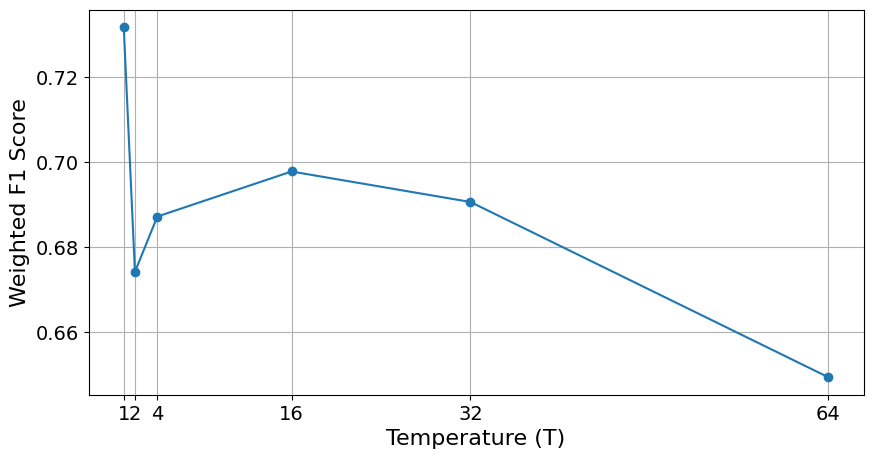

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(temperatures, F1_scores, marker='o')
plt.xlabel('Temperature (T)', fontsize=16)
plt.ylabel('Weighted F1 Score', fontsize=16)
# plt.title('Weighted F1 Score vs Temperature for Knowledge Distillation')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(temperatures)  # Set x-ticks to the specified temperatures only
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T2Q6.png', dpi=300, bbox_inches='tight')
plt.show()

F1 Score answers the question: "How well does the model balance precision and recall?" A higher F1 Score indicates a better balance and overall performance

# Comparing the teacher and student model (number of of parameters)

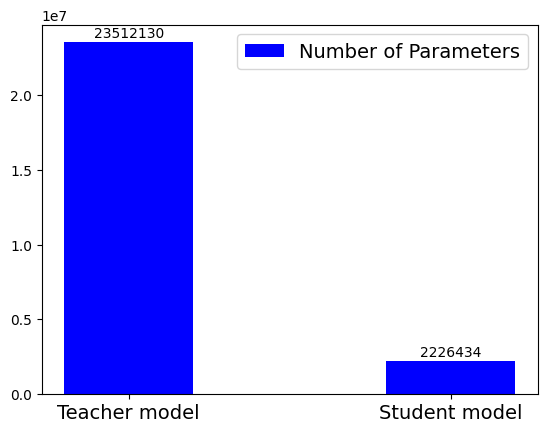

In [31]:
params_teacher_model = sum(p.numel() for p in teacher.model.parameters())
params_student_model = sum(p.numel() for p in student_KD.model.parameters())

labels = ['Teacher model', 'Student model']
params = [params_teacher_model, params_student_model]

x = range(len(labels))

# Create bar plot
bars = plt.bar(x, params, width=0.4, label='Number of Parameters', color='b', align='center')

# Add exact numbers on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005 * max(params), round(yval, 2), ha='center', va='bottom', fontsize=10)

# plt.xlabel('Models')
# plt.title('Number of parameter comparison')
plt.xticks(x, labels, fontsize=14)
plt.legend(fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T2Q8.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparing the teacher and student model (FLOPs)

In [33]:
!pip install thop

In [34]:
from thop import profile

FLOPs for Teacher model (ResNet50): 4,131,698,688.0
FLOPs for Student model (MobileNetV2): 326,209,280.0


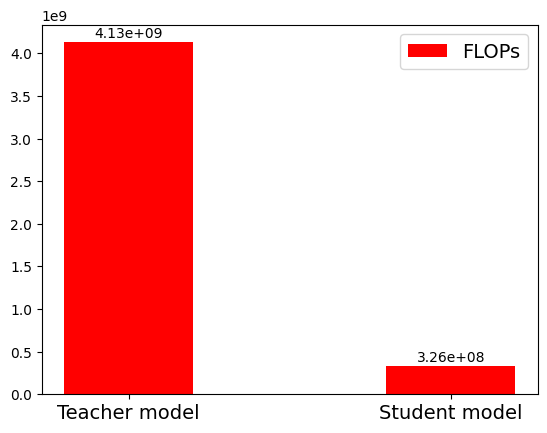

In [35]:
for inputs, _ in train_dataloader:
    # Get a single image from the batch
    # add an extra batch dimension to the image, as the models expect a batch of
    # images as input, not a single image.
    single_image = inputs[0].unsqueeze(0).to(device)
    break

# Calculate FLOPs
teacher_flops, _ = profile(teacher.model, inputs=(single_image,), verbose=False)
student_flops, _ = profile(student_KD.model, inputs=(single_image,), verbose=False)

# Print FLOPs
print("FLOPs for Teacher model (ResNet50): {:,}".format(teacher_flops))
print("FLOPs for Student model (MobileNetV2): {:,}".format(student_flops))

# Bar plot
labels = ['Teacher model', 'Student model']
flops = [teacher_flops, student_flops]
x = range(len(labels))

bars = plt.bar(x, flops, width=0.4, label='FLOPs', color='r', align='center')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005 * max(flops), f'{yval:.2e}', ha='center', va='bottom', fontsize=10)

# plt.xlabel('Models')
# plt.title('FLOPs Comparison')
plt.xticks(x, labels, fontsize=14)
plt.legend(fontsize=14)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T2Q8_2.png', dpi=300, bbox_inches='tight')
plt.show()

# Model creation for subclass distillation

In [45]:
NUM_SUBCLASSES_PER_CLASS = 5

**Teacher model**

In [46]:
class Teacher_SD:
    def __init__(self, device, num_classes=2, learning_rate=0.0001):
        self.device = device
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = self.initialize_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.initialize_optimizer()

    def initialize_model(self):
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = True
        model.fc = nn.Linear(model.fc.in_features, self.num_classes * NUM_SUBCLASSES_PER_CLASS)
        model = model.to(self.device)
        return model

    def initialize_optimizer(self):
        params_to_update = list(self.model.layer4.parameters()) + list(self.model.fc.parameters())
        optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
        return optimizer

    def print_model(self):
        print(self.model)

    def print_trainable_layers(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f"Trainable layer: {name}")
            else:
                print(f"Non-trainable layer: {name}")

**Student model**

In [47]:
class Student_SD:
    def __init__(self, device, num_classes=2, learning_rate=0.001):
        self.device = device
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        self.model = self.initialize_model()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.initialize_optimizer()

    def initialize_model(self):
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Modify the classifier
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, self.num_classes * NUM_SUBCLASSES_PER_CLASS)
        model = model.to(self.device)
        return model

    def initialize_optimizer(self):
        # Update only the parameters of the classifier layer
        params_to_update = list(self.model.classifier[1].parameters())
        optimizer = optim.Adam(params_to_update, lr=self.learning_rate)
        return optimizer

    def print_model(self):
        print(self.model)

    def print_trainable_layers(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f"Trainable layer: {name}")
            else:
                print(f"Non-trainable layer: {name}")

# Train and evaluation function for subclass distillation

In [48]:
class SDTeacherTrainingLoss(torch.nn.Module):
    def __init__(self, beta=0.1):
        super(SDTeacherTrainingLoss, self).__init__()
        self.beta = beta

    def forward(self, subclass_logits, labels):

        batch_size = subclass_logits.size(0)

        softmax_probs = torch.nn.functional.softmax(subclass_logits, dim=-1)
        softmax_probs = softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)
        summed_probs = softmax_probs.sum(dim=-1)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=2)
        cross_entropy_loss = -torch.mean(torch.sum(labels_one_hot.float() * torch.log(summed_probs + 1e-9), dim=-1))

        mean = torch.mean(subclass_logits, dim=1, keepdim=True)
        variance = torch.var(subclass_logits, dim=1, keepdim=True)
        normalized_subclass_logits = (subclass_logits - mean) / torch.sqrt(variance + 1e-9)

        logits_product_matrix = torch.mm(normalized_subclass_logits, normalized_subclass_logits.t()) / 1.0
        exp_logits_product_matrix = torch.exp(logits_product_matrix)
        numerators = torch.diag(exp_logits_product_matrix)
        denominators = torch.mean(exp_logits_product_matrix, dim=-1)
        aux_losses = torch.log(numerators / denominators)

        L_aux = -torch.mean(aux_losses)
        total_loss = cross_entropy_loss + self.beta * L_aux

        return total_loss

In [49]:
class SDStudentTrainingLoss(torch.nn.Module):
    def __init__(self, alpha=0.4, temperature=4.0):
        super(SDStudentTrainingLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature

    def forward(self, subclass_logits_teacher, subclass_logits_student, labels):

        batch_size = subclass_logits_student.size(0)

        teacher_softmax_probs = torch.nn.functional.softmax(subclass_logits_teacher / self.temperature, dim=-1)
        teacher_softmax_probs = teacher_softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)

        student_log_softmax_probs = torch.nn.functional.log_softmax(subclass_logits_student / self.temperature, dim=-1)
        student_log_softmax_probs = student_log_softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)

        loss_soft = -(teacher_softmax_probs * student_log_softmax_probs).sum(dim=-1).mean() * (self.temperature ** 2)

        student_softmax_probs = torch.nn.functional.softmax(subclass_logits_student, dim=-1)
        student_softmax_probs = student_softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)
        summed_probs = student_softmax_probs.sum(dim=-1)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=2)

        loss_hard = -torch.mean(torch.sum(labels_one_hot.float() * torch.log(summed_probs + 1e-9), dim=-1))

        # Combine the two losses
        loss = self.alpha * loss_soft + (1 - self.alpha) * loss_hard

        return loss

In [50]:
class SDTestLoss(torch.nn.Module):
    def __init__(self):
        super(SDTestLoss, self).__init__()

    def forward(self, subclass_logits, labels):

        batch_size = subclass_logits.size(0)

        softmax_probs = torch.nn.functional.softmax(subclass_logits, dim=-1)
        softmax_probs = softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)
        summed_probs = softmax_probs.sum(dim=-1)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=2)
        loss = -torch.mean(torch.sum(labels_one_hot.float() * torch.log(summed_probs + 1e-9), dim=-1))

        return loss

In [51]:
def train_teacher_model(model_wrapper, save_path, num_epochs=25):

    test_loss_min = np.Inf  # Track change in test loss
    training_criterion = SDTeacherTrainingLoss()
    test_criterion = SDTestLoss()

    for epoch in range(1, num_epochs + 1):
        # Track test loss
        test_loss = 0.0
        model_wrapper.model.train()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(model_wrapper.device), labels.to(model_wrapper.device)
            # Clear the gradients of all optimized variables
            model_wrapper.optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model_wrapper.model(inputs)
            # Compute the batch loss
            loss = training_criterion(output, labels)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            model_wrapper.optimizer.step()

        model_wrapper.model.eval()
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(model_wrapper.device), labels.to(model_wrapper.device)
            output = model_wrapper.model(inputs)

            loss = test_criterion(output, labels)
            test_loss += loss.item() * inputs.size(0)

        test_loss = test_loss / len(test_dataloader.dataset)
        print('Epoch: {} \tTest Loss: {:.6f}'.format(epoch, test_loss))

        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
                test_loss_min, test_loss))
            torch.save(model_wrapper.model.state_dict(), save_path)
            test_loss_min = test_loss

In [52]:
def train_student_model(teacher_model_wrapper, student_model_wrapper, save_path, num_epochs=25):

    test_loss_min = np.Inf  # Track change in test loss
    training_criterion = SDStudentTrainingLoss()
    test_criterion = SDTestLoss()

    # Set teacher to evaluation mode
    teacher_model_wrapper.model.eval()

    for epoch in range(1, num_epochs+1):
        test_loss = 0.0
        student_model_wrapper.model.train()

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(student_model_wrapper.device), labels.to(student_model_wrapper.device)
            student_model_wrapper.optimizer.zero_grad()
            # Get teacher's outputs
            with torch.no_grad():
                teacher_outputs = teacher_model_wrapper.model(inputs)
            # Get student's outputs
            student_outputs = student_model_wrapper.model(inputs)

            loss = training_criterion(teacher_outputs, student_outputs, labels)

            # Backpropagate
            loss.backward()
            student_model_wrapper.optimizer.step()

        student_model_wrapper.model.eval()
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(student_model_wrapper.device), labels.to(student_model_wrapper.device)
            output = student_model_wrapper.model(inputs)
            loss = test_criterion(output, labels)
            test_loss += loss.item() * inputs.size(0)

        test_loss = test_loss / len(test_dataloader.dataset)
        print('Epoch: {} \tTest Loss: {:.6f}'.format(epoch, test_loss))

        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Model Parameters Saved'.format(
                test_loss_min, test_loss))
            torch.save(student_model_wrapper.model.state_dict(), save_path)
            test_loss_min = test_loss

In [53]:
def evaluate_SD_model(model_wrapper, model_parameters_path):

    classes = ["SSA", "HP"]
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    all_labels = []
    all_preds = []

    model_wrapper.model.load_state_dict(torch.load(model_parameters_path))
    model_wrapper.model.eval()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model_wrapper.model(inputs)

        softmax_probs = torch.nn.functional.softmax(output, dim=-1)
        softmax_probs = softmax_probs.view(-1, 2, NUM_SUBCLASSES_PER_CLASS)
        summed_probs = softmax_probs.sum(dim=-1)

        # _, pred = torch.max(output, 1)
        _, pred = torch.max(summed_probs, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(pred.cpu().numpy())

    results = {
        "class_correct": class_correct,
        "class_total": class_total,
        "overall_accuracy": 100. * np.sum(class_correct) / np.sum(class_total),
        "all_labels": all_labels,
        "all_preds": all_preds,
        "classes": classes
    }

    return results

def print_evaluation_results(results):
    classes = results["classes"]
    class_correct = results["class_correct"]
    class_total = results["class_total"]
    all_labels = results["all_labels"]
    all_preds = results["all_preds"]

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('Test Accuracy (Overall): %2d%% (%2d/%2d)\n' % (
        results["overall_accuracy"],
        np.sum(class_correct), np.sum(class_total)))

    for i, class_name in enumerate(classes):
        f1 = f1_score(all_labels, all_preds, pos_label=i)
        print('F1 Score for %s: %.6f' % (class_name, f1))

    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    print('Weighted F1 Score: {:.6f}\n'.format(weighted_f1))

    print(classification_report(all_labels, all_preds, target_names=classes, digits=6))

# Train and evaluation

**Teacher**

In [54]:
teacher_sd = Teacher_SD(device)

In [55]:
train_teacher_model(teacher_sd, save_path='teacher_SD_model_parameters.pth')

Epoch: 1 	Test Loss: 0.523142
Test loss decreased (inf --> 0.523142).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.524908
Epoch: 3 	Test Loss: 0.418891
Test loss decreased (0.523142 --> 0.418891).  Model Parameters Saved
Epoch: 4 	Test Loss: 0.436713
Epoch: 5 	Test Loss: 0.392098
Test loss decreased (0.418891 --> 0.392098).  Model Parameters Saved
Epoch: 6 	Test Loss: 0.434055
Epoch: 7 	Test Loss: 0.395858
Epoch: 8 	Test Loss: 0.413307
Epoch: 9 	Test Loss: 0.525717
Epoch: 10 	Test Loss: 0.416417
Epoch: 11 	Test Loss: 0.527604
Epoch: 12 	Test Loss: 0.486179
Epoch: 13 	Test Loss: 0.489685
Epoch: 14 	Test Loss: 0.495444
Epoch: 15 	Test Loss: 0.525766
Epoch: 16 	Test Loss: 0.516287
Epoch: 17 	Test Loss: 0.504404
Epoch: 18 	Test Loss: 0.480850
Epoch: 19 	Test Loss: 0.484384
Epoch: 20 	Test Loss: 0.576267
Epoch: 21 	Test Loss: 0.525736
Epoch: 22 	Test Loss: 0.569274
Epoch: 23 	Test Loss: 0.567591
Epoch: 24 	Test Loss: 0.556982
Epoch: 25 	Test Loss: 0.570054


In [56]:
teacher_sd_results = evaluate_SD_model(teacher_sd, model_parameters_path='teacher_SD_model_parameters.pth')
print_evaluation_results(teacher_sd_results)

Test Accuracy of   SSA: 79% (287/360)
Test Accuracy of    HP: 86% (536/617)
Test Accuracy (Overall): 84% (823/977)

F1 Score for SSA: 0.788462
F1 Score for HP: 0.874388
Weighted F1 Score: 0.842726

              precision    recall  f1-score   support

         SSA   0.779891  0.797222  0.788462       360
          HP   0.880131  0.868720  0.874388       617

    accuracy                       0.842375       977
   macro avg   0.830011  0.832971  0.831425       977
weighted avg   0.843195  0.842375  0.842726       977



**Student**

In [63]:
student_sd = Student_SD(device)

In [64]:
train_student_model(teacher_sd, student_sd, save_path='student_SD_model_parameters.pth')

Epoch: 1 	Test Loss: 0.596202
Test loss decreased (inf --> 0.596202).  Model Parameters Saved
Epoch: 2 	Test Loss: 0.547911
Test loss decreased (0.596202 --> 0.547911).  Model Parameters Saved
Epoch: 3 	Test Loss: 0.553398
Epoch: 4 	Test Loss: 0.557053
Epoch: 5 	Test Loss: 0.503429
Test loss decreased (0.547911 --> 0.503429).  Model Parameters Saved
Epoch: 6 	Test Loss: 0.515379
Epoch: 7 	Test Loss: 0.561659
Epoch: 8 	Test Loss: 0.560826
Epoch: 9 	Test Loss: 0.486459
Test loss decreased (0.503429 --> 0.486459).  Model Parameters Saved
Epoch: 10 	Test Loss: 0.535069
Epoch: 11 	Test Loss: 0.510933
Epoch: 12 	Test Loss: 0.496637
Epoch: 13 	Test Loss: 0.511794
Epoch: 14 	Test Loss: 0.513915
Epoch: 15 	Test Loss: 0.571807
Epoch: 16 	Test Loss: 0.510188
Epoch: 17 	Test Loss: 0.564590
Epoch: 18 	Test Loss: 0.505903
Epoch: 19 	Test Loss: 0.518347
Epoch: 20 	Test Loss: 0.521542
Epoch: 21 	Test Loss: 0.550421
Epoch: 22 	Test Loss: 0.560824
Epoch: 23 	Test Loss: 0.525341
Epoch: 24 	Test Loss: 0.4

In [65]:
student_sd_results = evaluate_SD_model(student_sd, model_parameters_path='student_SD_model_parameters.pth')
print_evaluation_results(student_sd_results)

Test Accuracy of   SSA: 50% (180/360)
Test Accuracy of    HP: 86% (535/617)
Test Accuracy (Overall): 73% (715/977)

F1 Score for SSA: 0.578778
F1 Score for HP: 0.803303
Weighted F1 Score: 0.720571

              precision    recall  f1-score   support

         SSA   0.687023  0.500000  0.578778       360
          HP   0.748252  0.867099  0.803303       617

    accuracy                       0.731832       977
   macro avg   0.717637  0.683549  0.691041       977
weighted avg   0.725690  0.731832  0.720571       977



# XAI method to explain models

Reference:

[1] https://medium.datadriveninvestor.com/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

In [66]:
import random
import matplotlib.gridspec as gridspec

In [67]:
def compute_saliency(model_wrapper, input_image):
    model_wrapper.model.eval()
    input_image = input_image.to(device)
    # Make sure that any operation performed on input_image will be tracked, so
    # that gradients can be computed with respect to it later on
    input_image.requires_grad_()

    # Forward pass
    outputs = model_wrapper.model(input_image)
    score, index = outputs.max(1)

    # Backward pass
    score.backward()

    # Saliency would be the gradient with respect to the input image now.
    saliency = input_image.grad.data
    saliency = saliency.abs().squeeze().cpu().numpy()

    return saliency

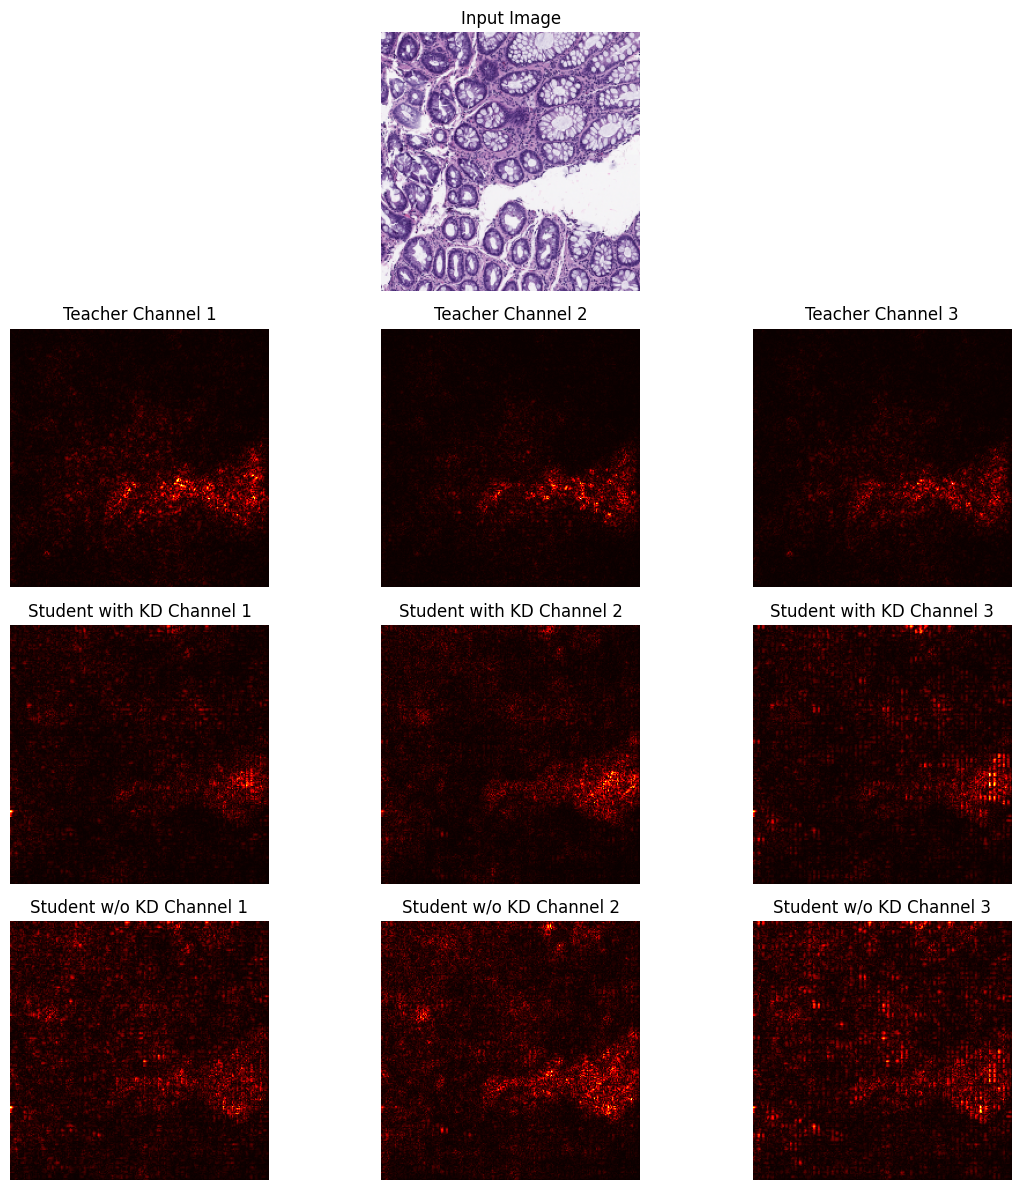

In [86]:
# Convert the test_dataloader to a list for easier indexing
test_list = list(test_dataloader)
random_index = np.random.randint(0, len(test_list))
# sample_images, _ = test_list[random_index]
# sample_images, _ = test_list[1]
sample_images, _ = test_list[13]
sample_image = sample_images[0].unsqueeze(0)  # Take the first image from the batch

# Compute saliency for each model
saliency_teacher = compute_saliency(teacher, sample_image)
saliency_student_KD = compute_saliency(student_KD, sample_image)
saliency_student_scratch = compute_saliency(student_scratch, sample_image)

# Create a figure and a gridspec layout
plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(4, 4)

# Input Image
ax0 = plt.subplot(gs[0, 1:2])
sample_image_np = sample_image.squeeze(0).permute(1, 2, 0).numpy()
ax0.imshow(sample_image_np)
ax0.set_title('Input Image')
ax0.axis('off')

cmap = 'hot'

# Teacher Saliency Map - Channel 1
ax1 = plt.subplot(gs[1, 0])
ax1.imshow(saliency_teacher[0], cmap=cmap)
ax1.set_title('Teacher Channel 1')
ax1.axis('off')

# Teacher Saliency Map - Channel 2
ax2 = plt.subplot(gs[1, 1])
ax2.imshow(saliency_teacher[1], cmap=cmap)
ax2.set_title('Teacher Channel 2')
ax2.axis('off')

# Teacher Saliency Map - Channel 3
ax3 = plt.subplot(gs[1, 2])
ax3.imshow(saliency_teacher[2], cmap=cmap)
ax3.set_title('Teacher Channel 3')
ax3.axis('off')

# Student with KD Saliency Map - Channel 1
ax4 = plt.subplot(gs[2, 0])
ax4.imshow(saliency_student_KD[0], cmap=cmap)
ax4.set_title('Student with KD Channel 1')
ax4.axis('off')

# Student with KD Saliency Map - Channel 2
ax5 = plt.subplot(gs[2, 1])
ax5.imshow(saliency_student_KD[1], cmap=cmap)
ax5.set_title('Student with KD Channel 2')
ax5.axis('off')

# Student with KD Saliency Map - Channel 3
ax6 = plt.subplot(gs[2, 2])
ax6.imshow(saliency_student_KD[2], cmap=cmap)
ax6.set_title('Student with KD Channel 3')
ax6.axis('off')

# Student without KD Saliency Map - Channel 1
ax7 = plt.subplot(gs[3, 0])
ax7.imshow(saliency_student_scratch[0], cmap=cmap)
ax7.set_title('Student w/o KD Channel 1')
ax7.axis('off')

# Student without KD Saliency Map - Channel 2
ax8 = plt.subplot(gs[3, 1])
ax8.imshow(saliency_student_scratch[1], cmap=cmap)
ax8.set_title('Student w/o KD Channel 2')
ax8.axis('off')

# Student without KD Saliency Map - Channel 3
ax9 = plt.subplot(gs[3, 2])
ax9.imshow(saliency_student_scratch[2], cmap=cmap)
ax9.set_title('Student w/o KD Channel 3')
ax9.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ECE1512/Project A/Figures/T2Q13.png', dpi=300, bbox_inches='tight')
plt.show()

# Question 3

By freezing most of the layer parameters on a pre-trained model and fine tuning only a few top layers, tranfer learning allows the student model to leverage the primitive feature identifier of the model, which is learned from training on a large dataset, and focus on the learning of task specific features. This allows the student model to be trained more efficiently and with relatively less data for a customized task. In addition, with the help of knowledge distillation, knowledge from an even larger model can be transfered to the student model, which essentially allows student model to use existing pre-trained model's knowledge to better mimic the behaviour of teacher model.

I think pre-trained weights do help the teacher and student models perform well on the MHIST dataset, given that we only have very limited data for training. If we train ResNet50 and MobileNetV2 from scratch using the data we have, we can anticipate overfitting and very poor generalization capability from them.

In my experiment, knowledge transfer does increase teh student's performance by a small margin, compared to student model from scratch. The weighted F1 score of student model after knowledge distillation from teacher model is 0.721, and the weighted F1 score of student model learned from scratch is 0.698, which suggests that knowledge distillation has provided a noticeable improvement in the performance of the student model.